## Simulating data to benchmark FC algorithms

In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat, loadmat
import os
import networkx as nx

WARNING    C:\Users\Jure\AppData\Local\Temp\ipykernel_12316\988017877.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).toarray()
 [py.warnings]


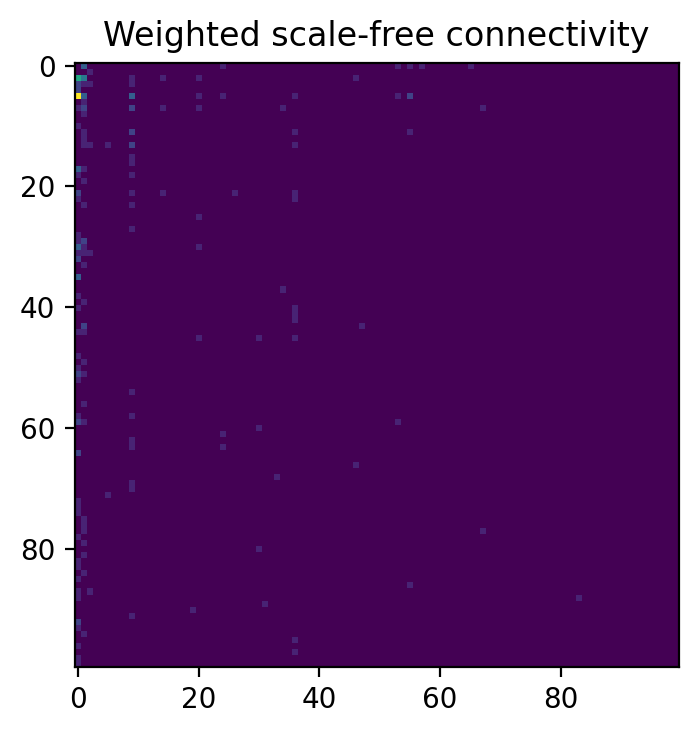

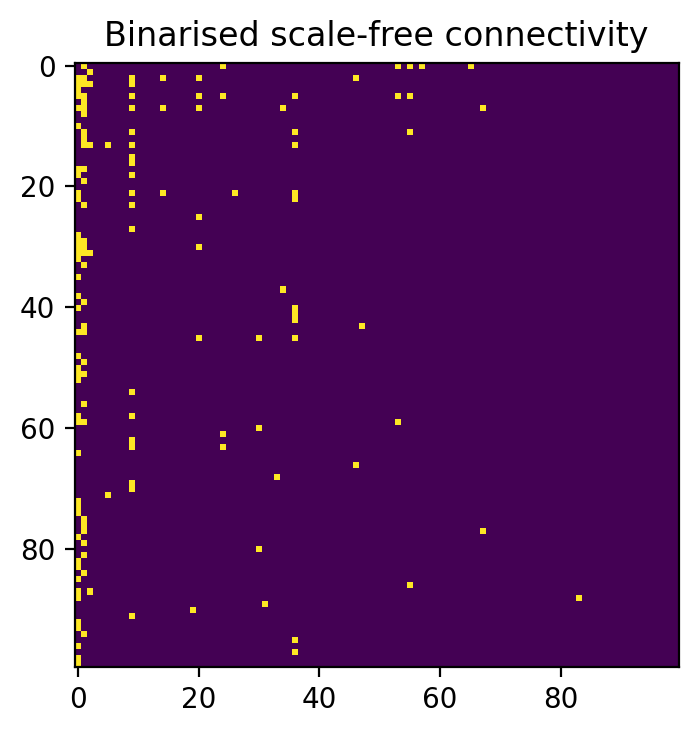

In [2]:
N = 100
G = nx.scale_free_graph(N, seed=42)
adj = nx.adjacency_matrix(G).toarray()
np.fill_diagonal(adj, 0) # this will somewhat alter scale-free topology
adj_bin = np.copy(adj) 
adj_bin[adj_bin>=1]=1

plt.figure(dpi=200)
plt.imshow(adj)
plt.title('Weighted scale-free connectivity')
plt.figure(dpi=200)
plt.imshow(adj_bin)
plt.title('Binarised scale-free connectivity')

syns = np.nonzero(adj_bin) # sparse matrix format expected by brian

In [11]:
# defining parameters

# general
identifier='sim05_2022-04-15_r2'
# standardised format 
    #'sim##_YYYY_MM_DD_r#'; 
        #'sim##' is incremented for a different network instantiation, 
        #'r#' is incrememnted for different simulations of same network instantiation
deve_nw_path='C:/Users/Jure/Documents/CossartLab/code/deve-networks/data' # path to general ('ani' and 'sim') data folder

# topology
top = 'sfree' # 'rand' (random) or 'sfree' (scale-free)

# dynamics
sig = 0.08 # independent noise
N = 100 # neurons
threshold = 1 
reset = 0.9 # reset value after a spike initiation
refractory = 2*ms # absolute refracotry period
rest_pot_I = 0.9 # steady state value for membrane dynamics ('resting potential')
mem_tau = 10*ms # membrane time constant
syn_w = 0.06 # synaptic weight
syn_dt = 1*ms # synaptic delay
p_connect = 0.01 if top == 'rand' else print('') # synnaptic connection probability




WARNING    C:\Users\Jure\AppData\Local\Temp\ipykernel_12316\4085653784.py:30: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(sf_graph).toarray()
 [py.warnings]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=0. s for a duration of 1.2 ks
5.0569 s (0%) simulated in 10s, estimated 39m 23s remaining.
8.7498 s (0%) simulated in 20s, estimated 45m 23s remaining.
13.8704 s (1%) simulated in 30s, estimated 42m 46s remaining.
17.7182 s (1%) simulated in 40s, estimated 44m 29s remaining.
20.6604 s (1%) simulated in 50s, estimated 47m 34s remaining.
22.6656 s (1%) simulated in 1m 0s, estimated 51m 57s remaining.
23.2997 s (1%) simulated in 1m 10s, estimated 58m 56s remaining.
24.0616 s (2%) simulated in 1m 20s, estimated 1h 5m 10s remaining.
24.724 s (2%) simulated in 1m 30s, estimated 1h 11m 19s remaining.
25.71 s (2%) simulated in 1m 40s, estimated 1h 16m 9s remaining.
26.5067 s (2%) simulated in 1m 50s, estimated 1h 21m 11s remaining.
27.5639 s (2%) simulated in 2m 0s, estimated 1h 25m 5s remaining.
28.6057 s (2%) simulated in 2m 10s, estimated 1h 28m 45s remaining.
29.2891 s (2%) simulated in 2m 20s, estimated 1h 33m 18s remaining.
30.2158 s (2%) simulated in 2m 30s, est

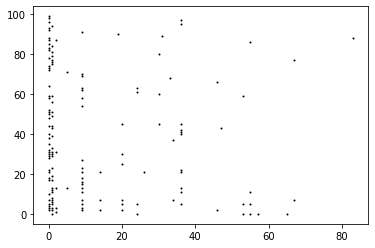

In [4]:
# define neurons and connectivity

start_scope()

eqs = '''
dv/dt = (I-v)/tau + sig*xi*tau**-0.5: 1
I : 1
tau : second
'''

G = NeuronGroup(N, eqs, threshold=f'v>{threshold}', reset=f'v = {reset}', refractory=refractory, method='euler')
G.I = rest_pot_I
G.tau = mem_tau #originally 10
S = Synapses(G, G, on_pre=f'v_post += {syn_w}', delay=syn_dt)

if top == 'rand':
    
    # connecting randomly
    S.connect(condition='i!=j', p=p_connect)

    # visualise connectivity
    figure()
    scatter(S.i, S.j, s=1, c='k')
    savefig('ground_truth.png')
    
elif top == 'sfree':
    
    # getting scale free network
    sf_graph = nx.scale_free_graph(N, seed=42)
    adj = nx.adjacency_matrix(sf_graph).toarray()
    np.fill_diagonal(adj, 0) # this will somewhat alter scale-free topology
    adj_bin = np.copy(adj) 
    adj_bin[adj_bin>=1]=1
    syns = np.nonzero(adj_bin) # sparse matrix format expected by brian
    
    # connecting scale-freely
    S.connect(i=syns[1],j=syns[0]) # hmmm - here think which are the incoming and which the outgoing

    # visualise connectivity
    figure()
    scatter(S.i, S.j, s=1, c='k')
    savefig('ground_truth.png')    
    
# run experiment
spikemon = SpikeMonitor(G)

run_for = 1200 # 1200 originally ('20 minutes')
run(run_for*second, report='stdout', report_period=10*second)

In [14]:
# binning at a particular imaging rate (binarised raster) and getting correlation matrix
imaging_rate = 4
n_neurons = N
all_hist = np.zeros((n_neurons, run_for*imaging_rate))
for n in range(n_neurons):
    all_hist[n,:] = np.histogram(spikemon.t[spikemon.i==n], bins=np.arange(0,run_for+0.0001,1/imaging_rate))[0]
    #all_hist.append(n_hist[0])

corr_mat = np.corrcoef(all_hist>2)
#adding zeros to diagonal (no self-connections) - for better visualisation
np.fill_diagonal(corr_mat, 0)

In [15]:
# exporting simulated data to compare different FC inference techniques

sim_data = {'syn_i': np.copy(S.i),
            'syn_j': np.copy(S.j),
           'st': np.copy(spikemon.t),
           'si': np.copy(spikemon.i),
           'imaging_rate': imaging_rate,
           'sts_binned': all_hist,
           'corr_mat': corr_mat}

t_stamp =  str(np.datetime64('now')).replace('-','').replace('T','_').replace(':', '')

os.makedirs(f'{deve_nw_path}/{identifier}/', exist_ok=False)

np.save(f'{deve_nw_path}/{identifier}/{identifier}.npy', sim_data)
savemat(f'{deve_nw_path}/{identifier}/{identifier}.mat', sim_data)

## Plotting everything

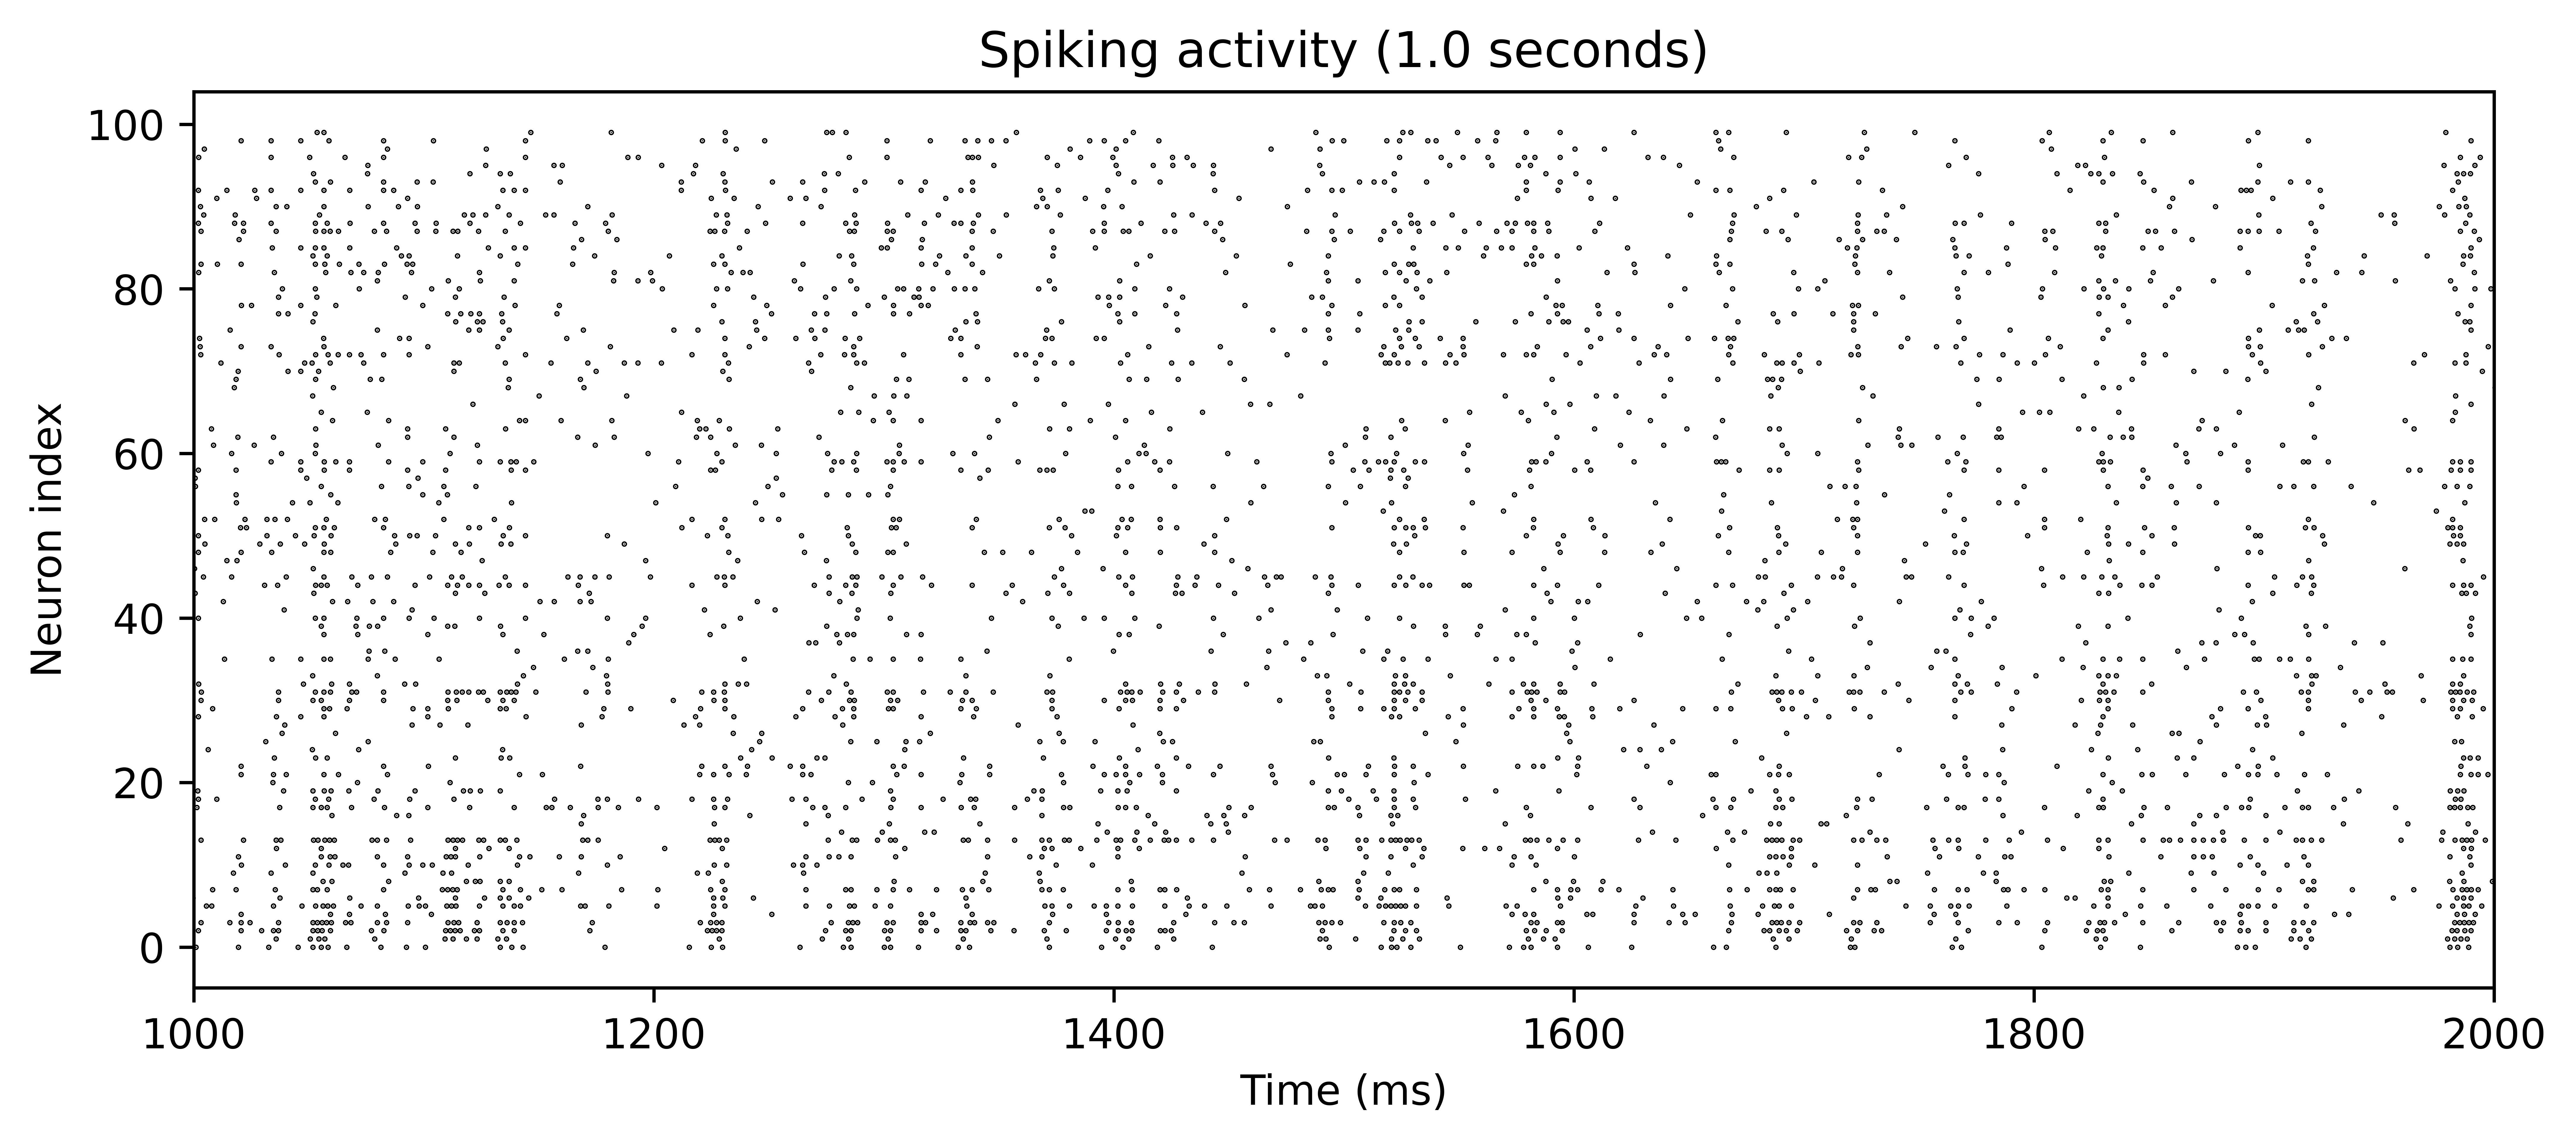

In [7]:
# plot spike times for each neuron (true raster)
xlim = [1000, 2000]
plt.figure(figsize=(10, 4), dpi=1000)
plt.scatter(spikemon.t[spikemon.i<100]/ms, spikemon.i[spikemon.i<100], s=0.1, c='k') # t is spike time, i is neuron id
xlabel('Time (ms)')
ylabel('Neuron index')
title(f'Spiking activity ({(xlim[1]-xlim[0])/1e3} seconds)')
plt.xlim(xlim)
savefig(f'figures/{t_stamp}_spiking_data.png')

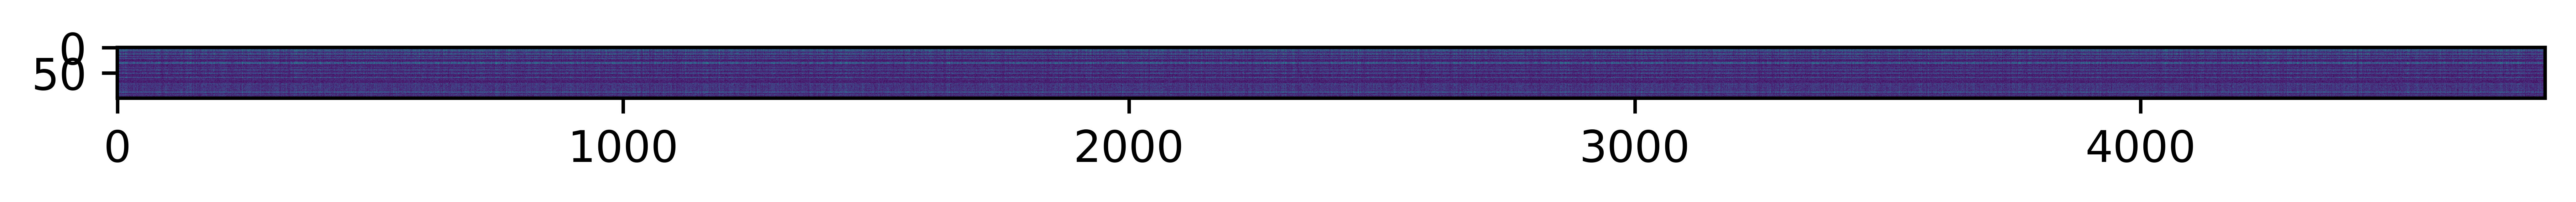

In [16]:
# plot histogram at a particular imaging rate
plt.figure(figsize=(10, 4), dpi=1000)
plt.imshow(all_hist)
savefig(f'figures/{t_stamp}_binned_30.png')

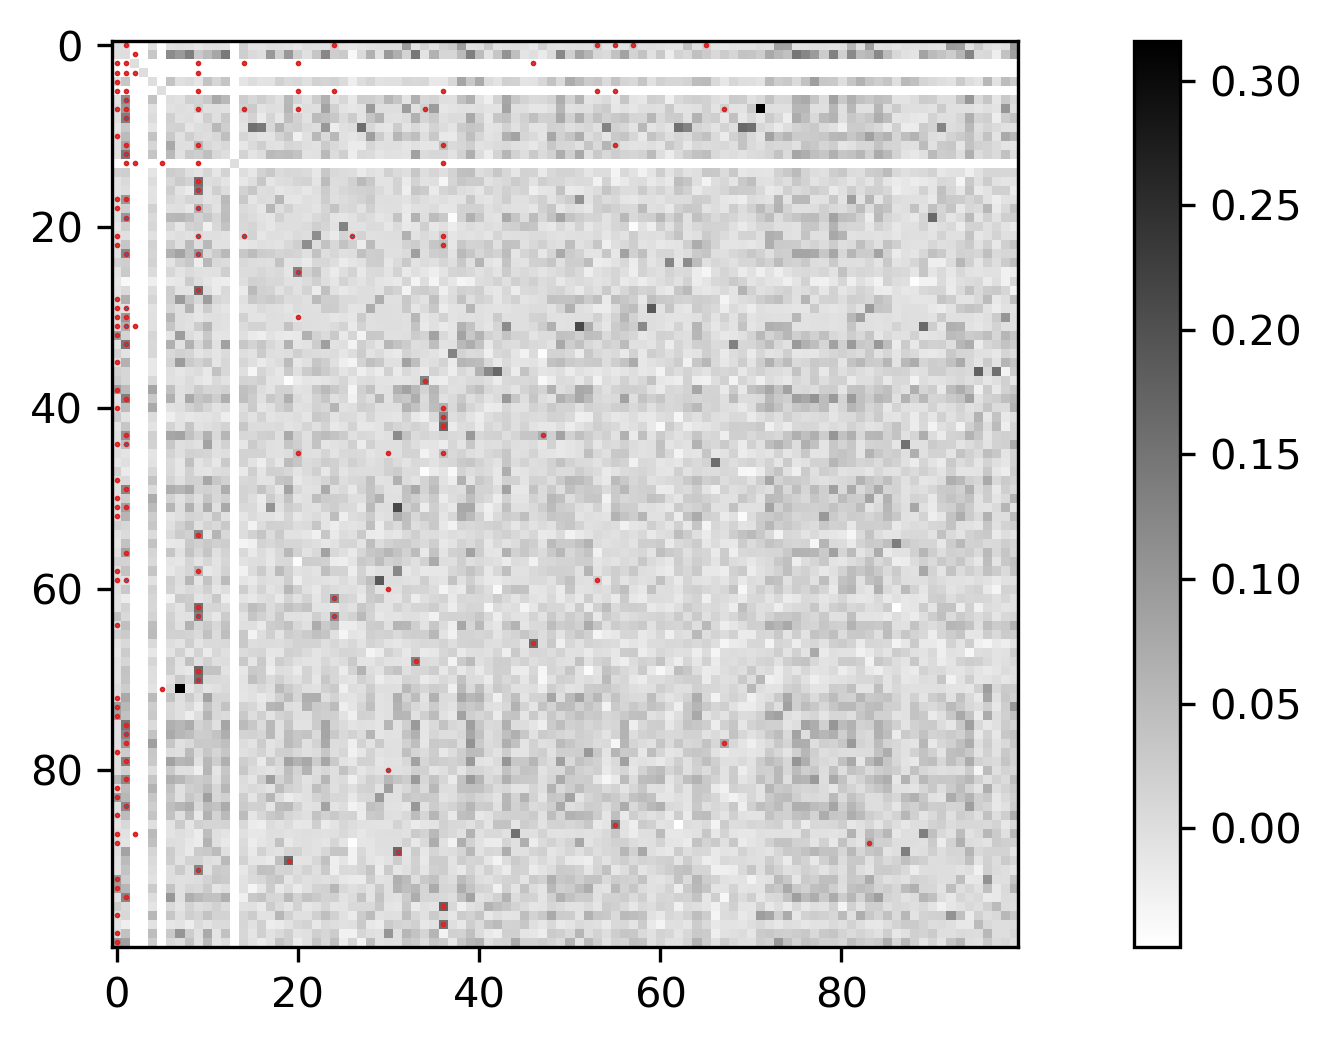

In [17]:
# THIS IS WITHOUT BINARISING but with binning + adding zeros on diagonal
#plotting
plt.figure(figsize=(10, 4), dpi=300)
plt.imshow(corr_mat, cmap='binary')
plt.colorbar()
scatter(S.i, S.j, s=0.1, facecolors=None, edgecolors='C3', marker='X')
savefig(f'figures/{t_stamp}_emp_vs_gt_directed.png')

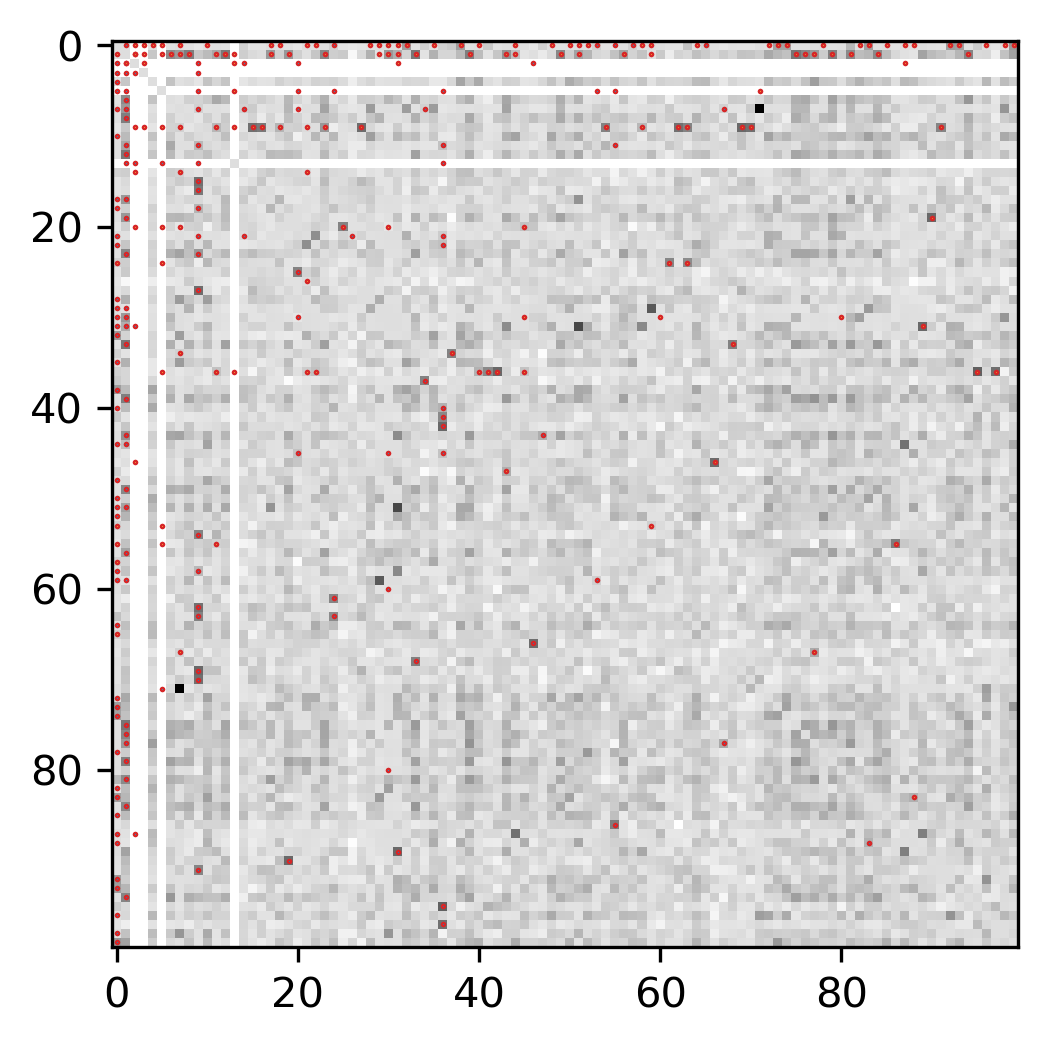

In [18]:
plt.figure(figsize=(10, 4), dpi=300)
plt.imshow(corr_mat, cmap='binary')
scatter(S.i, S.j, s=0.1, facecolors=None, edgecolors='C3', marker='X')
scatter(S.j, S.i, s=0.1, facecolors=None, edgecolors='C3', marker='X')
savefig(f'figures/{t_stamp}_emp_vs_gt_undirected.png')

## Comparing to MATLAB inference